In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV

import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
pd.set_option('max_columns',None)
pd.set_option('precision',3)

In [2]:
agri_data = pd.read_excel('Saha_et_al_2020_ERL_Data.xlsx', sheet_name=1)
agri_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2246 non-null   datetime64[ns]
 1   Year         2246 non-null   int64         
 2   Experiment   2246 non-null   object        
 3   DataUse      2246 non-null   object        
 4   Replication  2246 non-null   object        
 5   Month        2246 non-null   object        
 6   Vegetation   2246 non-null   object        
 7   VegType      2246 non-null   object        
 8   N2O          2246 non-null   float64       
 9   N_rate       2246 non-null   int64         
 10  PP2          2246 non-null   float64       
 11  PP7          2246 non-null   float64       
 12  AirT         2246 non-null   float64       
 13  DAF_TD       2246 non-null   int64         
 14  DAF_SD       2246 non-null   int64         
 15  WFPS25cm     2194 non-null   float64       
 16  NH4   

In [3]:
agri_data.head()

,Date,Year,Experiment,DataUse,Replication,Month,Vegetation,VegType,N2O,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,Sand,SOM
0,2012-02-09,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.897,170,0.00,0.00,-2.0,276,241,0.667,11.046,22.941,62.5,637.5,1.174
1,2012-02-10,2012,BCSE_KBS,Building,R1,February,Corn,Annual,2.190,170,0.00,0.00,-2.4,277,242,0.641,11.008,22.960,62.5,637.5,1.174
2,2012-02-18,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.543,170,3.30,8.64,0.3,285,250,0.728,10.832,23.222,62.5,637.5,1.174
3,2012-02-19,2012,BCSE_KBS,Building,R1,February,Corn,Annual,3.343,170,0.00,8.13,-3.8,286,251,0.687,10.850,23.272,62.5,637.5,1.174
4,2012-03-16,2012,BCSE_KBS,Building,R1,March,Corn,Annual,2.948,170,1.02,8.39,17.6,312,277,0.716,10.205,24.207,62.5,637.5,1.174


In [4]:
def oversample(df, columnName):
    major = df.drop(columnName, axis=1)
    minor = df[columnName]
    
    oversampler = SMOTE()
    major, minor = oversampler.fit_resample(major, minor)
    
    df = pd.concat([major,minor],axis=1)
    return df

In [5]:
def preprocess_inputs(data):
    df1 = data.copy()
    
    # drop unnecessary columns
    # VegType is dropped i.e Variation is zero
    # DataUse is dropped i.e Does not Contribute to Predict N2O
    # Replication is dropped i.e Repition of Experiment in a Day
    # Sand column is dropped i.e High Correlation with SOM & Clay
    df1 = df1.drop(['Date','VegType','DataUse','Replication','Sand'], axis=1) 
    
    # Encode Categorical Data
    exp_dict = {'BCSE_KBS':1, 'MCSE-T2':2, 'Arlington WI':3}
    months_dict = {  'January': 1,
                     'February': 2,
                     'March': 3,
                     'April': 4,
                     'May': 5,
                     'June': 6,
                     'July': 7,
                     'August': 8,
                     'September': 9,
                     'October': 10,
                     'November': 11,
                     'December': 12}
    vegetation_dict = {"Corn": 1, "GLYMX": 2, "TRIAE": 3}

    df1['Experiment'] = df1['Experiment'].map(exp_dict)
    df1['Month']     = df1['Month'].map(months_dict)
    df1['Vegetation'] = df1['Vegetation'].map(vegetation_dict)
      
    train, test= train_test_split(df1, test_size=0.3, random_state=19)
    
    # Handle Null Values
    imputer = KNNImputer(n_neighbors=3, weights='uniform')
    
    train = pd.DataFrame(data=imputer.fit_transform(train), columns=train.columns)
    test  = pd.DataFrame(data=imputer.transform(train), columns=test.columns)
    
    # Handle Imbalanced Dataset
    train_bal = pd.DataFrame(data = oversample(train, 'Vegetation'), columns = train.columns)
    
    # train_bal = pd.DataFrame(data = oversample(train_bal,'Experiment'), columns = train_bal.columns)
    
    X_train = train_bal.drop('N2O', axis=1)
    y_train = train_bal['N2O']
    
    X_test = test.drop('N2O', axis=1)
    y_test = test['N2O']
    
    return X_train, y_train, X_test, y_test

In [26]:
X_train['Experiment'].unique()

array([1., 2., 3.])

In [25]:
X_train.columns

Index(['Year', 'Experiment', 'Month', 'Vegetation', 'N_rate', 'PP2', 'PP7',
       'AirT', 'DAF_TD', 'DAF_SD', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'SOM'],
      dtype='object')

In [6]:
X_train, y_train, X_test, y_test = preprocess_inputs(agri_data)
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(3861, 15) (3861,) (1572, 15) (1572,)


In [7]:
X_train.head()

,Year,Experiment,Month,Vegetation,N_rate,PP2,PP7,AirT,DAF_TD,DAF_SD,WFPS25cm,NH4,NO3,Clay,SOM
0,2016.0,1.0,9.0,1.0,170.0,0.0,16.00,18.50,130.0,91.0,0.607,6.452,14.963,62.500,1.174
1,2014.0,2.0,7.0,1.0,167.0,0.0,7.11,17.87,71.0,42.0,0.219,22.237,11.728,169.833,1.823
2,2016.0,1.0,6.0,1.0,170.0,2.0,1.00,20.50,36.0,363.0,0.600,6.355,23.093,62.500,1.174
3,2016.0,1.0,1.0,1.0,170.0,0.0,29.00,-0.80,247.0,200.0,0.660,10.542,22.967,62.500,1.174
4,2013.0,2.0,5.0,3.0,91.0,0.0,0.00,18.13,6.0,6.0,0.293,23.688,39.218,162.500,1.496


In [8]:
def model_training(X_train, X_test, y_train, y_test):
    original_models = {
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              '     XG Boost': XGBRegressor()
    }   
    # print(original_models)
    for name, model in original_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = np.round(mean_squared_error(y_pred, y_test),3)
        mae = np.round(mean_absolute_error(y_pred, y_test),3)
        rmse = np.round(np.sqrt(np.round(mean_squared_error(y_pred, y_test),3)),3)
        # test_score = np.round(r2_score(X_test,y_test)*100,3)
        print(f'{name} trained Succesfully with mse: {mse}, mae: {mae}, rmse: {rmse}')

In [9]:
model_training(X_train, X_test, y_train, y_test)

Decision Tree trained Succesfully with mse: 0.0, mae: 0.0, rmse: 0.0
Random Forest trained Succesfully with mse: 76.906, mae: 2.207, rmse: 8.77
     XG Boost trained Succesfully with mse: 0.978, mae: 0.682, rmse: 0.989


In [10]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.scores_)):
        print('Feature %d: %f' % (i, fs_func.scores_[i]))
    # plot the scores
    x = [i for i in range(len(fs_func.scores_))]
    y = fs_func.scores_
    plt.bar(x, y)
    plt.xticks(x, X_train.columns.to_list(), fontsize=12, rotation=90)
    plt.show()

def select_features_model_based(estimator, X_train, y_train, X_test, n=None):
    
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe.fit(X_train,y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    return X_train_rfe, X_test_rfe, rfe

def rfe_score_plot(rfe):

    plt.figure(figsize=(7,5))
    sns.barplot(y =X_train.columns, x = max(rfe.ranking_) - rfe.ranking_)
    plt.show()

Feature 0: 19.920039
Feature 1: 42.680612
Feature 2: 4.255536
Feature 3: 60.547178
Feature 4: 73.474099
Feature 5: 79.630121
Feature 6: 106.602972
Feature 7: 25.163798
Feature 8: 68.178918
Feature 9: 70.681433
Feature 10: 141.746806
Feature 11: 1894.672070
Feature 12: 852.061117
Feature 13: 31.728896
Feature 14: 180.843561


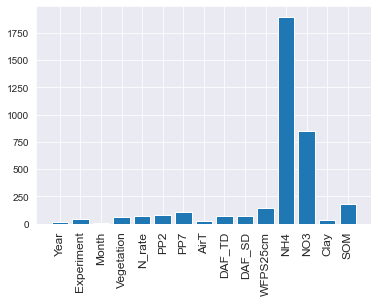

array([0.40316405, 0.5026196 , 0.60929792])

In [11]:
X_train_fs, X_test_fs, fs_ = select_features_corr_based(X_train, y_train, X_test, x=10)
fs_score_plot(fs_)

cv = cross_val_score(XGBRegressor(), X_train_fs, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

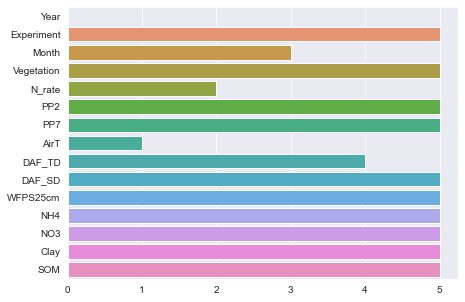

array([0.50468647, 0.39102826, 0.55243084])

In [12]:
X_train_rfe, X_test_rfe, rfe_ = select_features_model_based(XGBRegressor(), X_train, y_train, X_test, n=10)
plt.figure(figsize=(7,5))
sns.barplot(y =X_train.columns, x = max(rfe_.ranking_) - rfe_.ranking_)
plt.show()

cv = cross_val_score(XGBRegressor(), X_train_rfe, y_train, scoring='r2', cv=3, n_jobs=-1)
cv

In [13]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        scores['xgb'] = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
        
    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor(n_estimators=200, criterion='mse')
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
        models.append(rf)

    if 'dtree' in kwargs.keys() and kwargs['dtree']:
        dtree = DecisionTreeRegressor(criterion='mse')
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)
        scores['dtree'] = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
        models.append(dtree)
        
    return scores

In [14]:
print(modelling(X_train_fs, y_train, X_test_fs, y_test, xgb=True,rf=True,dtree=True))
print(modelling(X_train_rfe, y_train, X_test_rfe, y_test,xgb=True,rf=True,dtree=True))
print(modelling(X_train, y_train, X_test, y_test,xgb=True,rf=True,dtree=True))

{'xgb': 1.275, 'rf': 9.102, 'dtree': 0.0}
{'xgb': 1.241, 'rf': 8.751, 'dtree': 0.0}
{'xgb': 0.989, 'rf': 8.659, 'dtree': 0.0}


r2 score for base model: 0.999022


<AxesSubplot:>

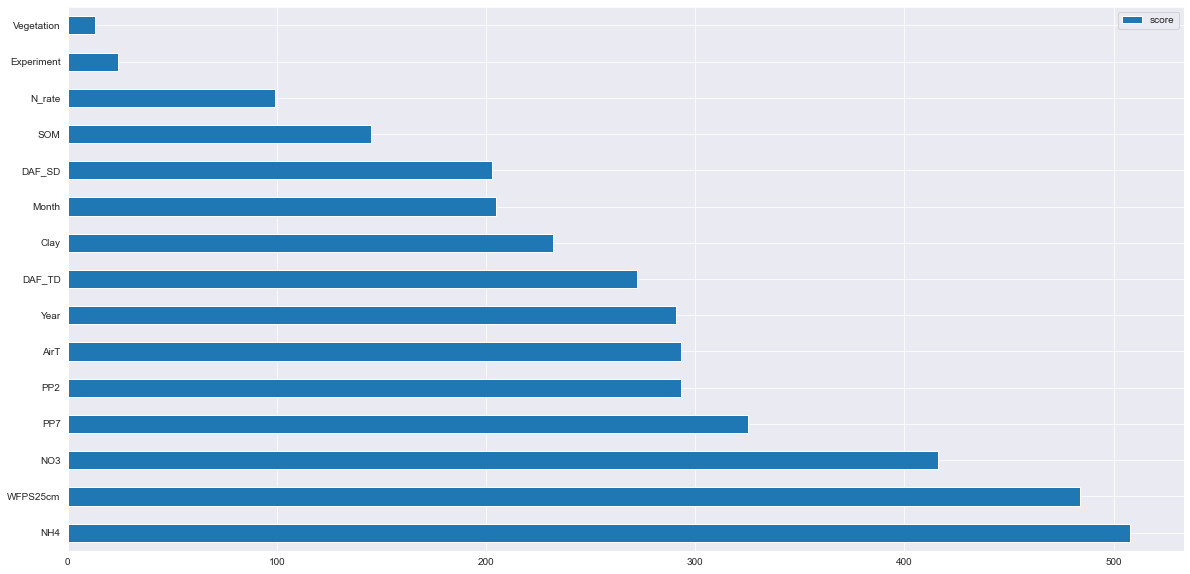

In [15]:
boost = XGBRegressor()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)
print("r2 score for base model: %f" % r2_score(y_test, y_pred))

feature_important = boost.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10))

In [17]:
cv = RepeatedKFold(n_splits= 30, n_repeats = 3, random_state = 19)

grid_params_xgb = [{ 'n_estimators': [100, 200],
                   'model__max_depth': [9,12],
                   'model__min_child_weight': [7,8],
                   'model__subsample': [i/10 for i in range(9,11)]
                    }]

XGB = GridSearchCV(estimator=boost,
            param_grid=grid_params_xgb,
            scoring='r2',
            cv=cv, 
            n_jobs= -1,
            verbose=1)


XGB.fit(X_train, y_train)

Fitting 90 folds for each of 16 candidates, totalling 1440 fits
[07:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "model__max_depth", "model__min_child_weight", "model__subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=30, random_state=19),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=4,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
    

In [18]:
print('Best MAE: %.3f' % XGB.best_score_) # model__max_depth=12, model__min_child_weight=8, model__subsample=1.0, n_estimators=200
boost_final = XGB.best_estimator_

Best MAE: -0.237


In [19]:
y_hat = boost_final.predict(X_test)
print(f'Training score : {XGB.score(X_train,y_train)}')

# print()
print('r2 score:', r2_score(y_test, y_hat))
print('MAE:', mean_absolute_error(y_test, y_hat))
print('MSE:', mean_squared_error(y_test, y_hat))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat)))

Training score : 0.9997958262035951
r2 score: 0.9998695330244035
MAE: 0.2540970054718085
MSE: 0.13058452403978896
RMSE: 0.36136480741736454


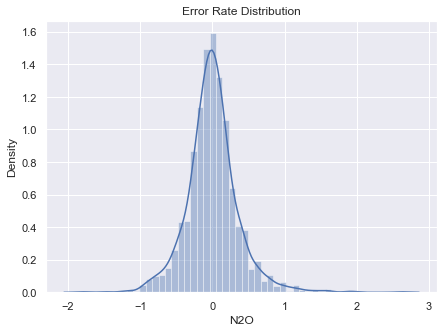

In [20]:
plt.figure(figsize = (7,5))
sns.set()
sns.distplot(y_test - y_hat)
plt.title("Error Rate Distribution");

In [22]:
import joblib
joblib.dump(boost_final,'XGB')

model = joblib.load('XGB')

In [14]:
df.describe(include='O').T

,count,unique,top,freq
Experiment,2246,3,BCSE_KBS,1094
Month,2246,12,July,285
Vegetation,2246,3,Corn,1845


In [18]:
df['Experiment'].value_counts(normalize=True)*100

BCSE_KBS        48.709
MCSE-T2         29.831
Arlington WI    21.460
Name: Experiment, dtype: float64

In [67]:
major_samples = X_train.drop('Vegetation',axis=1)
minor_samples = X_train['Vegetation']

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(major_samples,minor_samples)

In [68]:
X_res.shape, y_res.shape

((3861, 14), (3861,))

In [69]:
counter = Counter(y_res)
for k,v in counter.items():
    per = v / len(y_res) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=1287 (33.333%)
Class=3, n=1287 (33.333%)
Class=2, n=1287 (33.333%)


In [63]:
X_train_bal = pd.concat([X_res, y_res])
X_train_bal.shape

(7722, 15)

In [71]:
X_train_bal.head()

,0,AirT,Clay,DAF_SD,DAF_TD,Experiment,Month,NH4,NO3,N_rate,PP2,PP7,SOM,WFPS25cm,Year
0,NaN,18.50,62.500,91.0,130.0,1.0,9.0,6.452,14.963,170.0,0.0,16.00,1.174,0.607,2016.0
1,NaN,17.87,169.833,42.0,71.0,2.0,7.0,22.237,11.728,167.0,0.0,7.11,1.823,0.219,2014.0
2,NaN,20.50,62.500,363.0,36.0,1.0,6.0,6.355,23.093,170.0,2.0,1.00,1.174,0.600,2016.0
3,NaN,-0.80,62.500,200.0,247.0,1.0,1.0,10.542,22.967,170.0,0.0,29.00,1.174,0.660,2016.0
4,NaN,18.13,162.500,6.0,6.0,2.0,5.0,23.688,39.218,91.0,0.0,0.00,1.496,0.293,2013.0


In [59]:
major_samples1 = X_train_bal.drop('Vegetation',axis=1)
minor_samples1 = X_train_bal['Vegetation']

oversample = SMOTE()
X_res1, y_res1 = oversample.fit_resample(major_samples1,minor_samples1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [52]:
X.shape, y.shape

((1572, 14), (1572,))

In [46]:
df['Vegetation'].value_counts(normalize=True)*100

1    82.146
2     9.083
3     8.771
Name: Vegetation, dtype: float64

In [44]:
type(X_train)

pandas.core.frame.DataFrame

In [45]:
X_train['Vegetation'].value_counts()

1.0    1287
2.0     147
3.0     138
Name: Vegetation, dtype: int64

In [19]:
df['Month'].value_counts(normalize=True)*100

July         12.689
June         12.066
September    11.220
May          10.641
April         9.884
August        9.884
October       7.792
November      7.524
March         6.500
January       4.274
December      3.963
February      3.562
Name: Month, dtype: float64

In [22]:
df.describe(include=['int64','float64']).apply(lambda x: x.apply(lambda x: format(x,'g'))).T

,count,mean,std,min,25%,50%,75%,max
Year,2246,2011.93,3.61742,2002,2011,2013,2014,2017
N2O,2246,7.46861,28.4883,-7.4153,0.504316,1.97206,5.18762,593.072
N_rate,2246,142.994,56.1304,0,135,170,170,213
PP2,2246,5.21984,10.0641,0,0,0.51,6,95.25
PP7,2246,19.2453,23.7234,0,3.56,11.93,27,260.09
AirT,2246,12.4087,9.49015,-20.7,5.94,14.49,20.07,30.7
DAF_TD,2246,195.321,144.915,1,73.25,160,308.75,718
DAF_SD,2246,198.898,142.907,0,75,172,320,678
WFPS25cm,2194,0.531047,0.171868,0.0243877,0.390203,0.553853,0.680321,0.912113
NH4,2170,11.4514,13.2149,1.38339,5.29032,9.08128,12.1403,228.525
